In [ ]:
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_sm-0.5.1.tar.gz
!pip install medspacy
!python -m spacy download en_core_web_sm
!pip install --upgrade spacy
!pip list | grep spacy
!pip uninstall nltk -y
!pip install nltk

NLTK data path: ['/root/nltk_data', '/usr/nltk_data', '/usr/share/nltk_data', '/usr/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']
Setup Complete
Mounted at /content/drive
General Entities: []
Scientific Entities: [('Admission', 'ENTITY'), ('LF', 'ENTITY'), ('Invasive Procedure', 'ENTITY'), ('yo M', 'ENTITY'), ('melanoma', 'ENTITY')]
Medical Entities: []

Applying ClinicalBERT for additional entity extraction...


Some weights of BertForTokenClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



ClinicalBERT Extracted Entities: []
t-SNE computed. Data prepared for visualization.


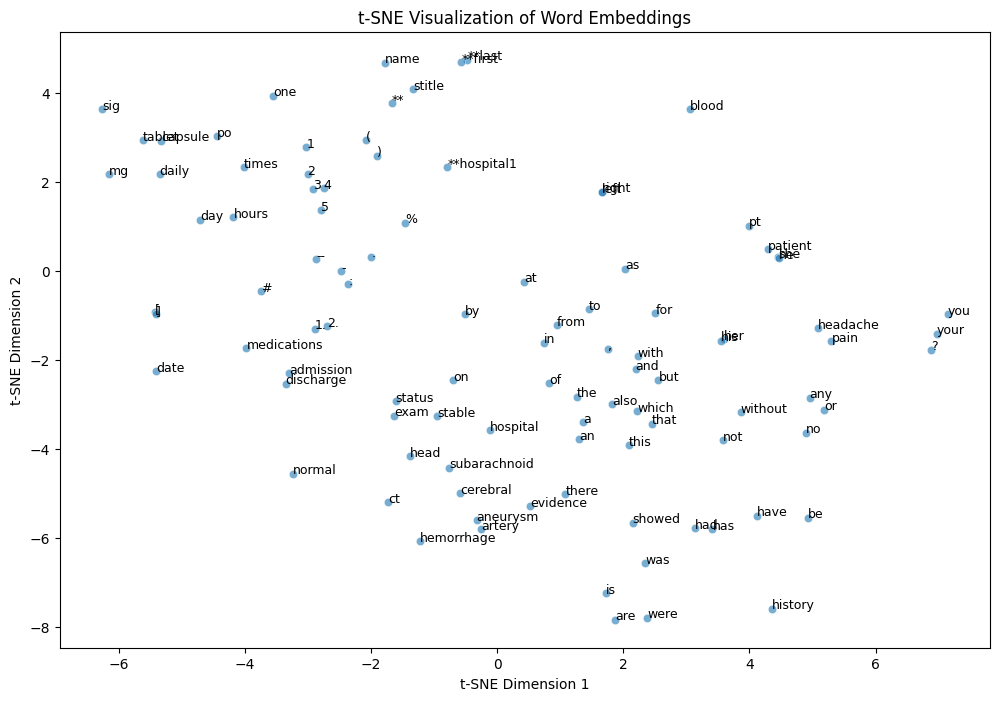

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Results saved and downloaded successfully.


In [5]:
# Import necessary libraries
import pandas as pd
from google.colab import files, drive
import spacy
import scispacy
import en_core_sci_sm
import medspacy
from gensim.models import Word2Vec
from nltk.tokenize import TreebankWordTokenizer  # Use TreebankWordTokenizer instead of word_tokenize
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
import logging
import os

# Setup logging
logging.basicConfig(level=logging.INFO)

# Download NLTK 'punkt' just in case, though TreebankWordTokenizer doesn't need it
nltk.download('punkt', quiet=True)
print("NLTK data path:", nltk.data.path)

print("Setup Complete")

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define file paths
diagnoses_icd_file_path = '/content/drive/MyDrive/DIAGNOSES_ICD.csv.gz'
noteevents_file_path = '/content/drive/MyDrive/NOTEEVENTS.csv.gz'

# Load and preprocess data
try:
    diagnoses_data = pd.read_csv(diagnoses_icd_file_path, compression='gzip')
    patients_430 = diagnoses_data[diagnoses_data['ICD9_CODE'] == '430']['SUBJECT_ID'].unique()

    notes_data = pd.read_csv(noteevents_file_path, compression='gzip')
    filtered_notes = notes_data[(notes_data['SUBJECT_ID'].isin(patients_430)) &
                                (notes_data['CATEGORY'] == 'Discharge summary')]

    logging.info("Data loading and filtering completed")
except Exception as e:
    logging.error(f"Error in data loading: {e}")

# Load NLP models
try:
    nlp_general = spacy.load('en_core_web_sm', disable=['parser', 'ner', 'vectors'])
    logging.info("General NLP model loaded successfully")
except OSError as e:
    logging.error(f"Failed to load the general spaCy model: {e}")

try:
    nlp_scientific = en_core_sci_sm.load()
    logging.info("Scientific NLP model loaded successfully")
except OSError as e:
    logging.error(f"Failed to load the scientific spaCy model: {e}")

try:
    nlp_medical = medspacy.load()
    logging.info("Medical NLP model loaded successfully")
except OSError as e:
    logging.error(f"Failed to load the medical spaCy model: {e}")

# Function to extract entities using a given NLP model
def extract_entities_with_nlp(text, nlp_model):
    doc = nlp_model(text)
    return [(entity.text, entity.label_) for entity in doc.ents]

# Extract entities from a sample note
sample_note = filtered_notes['TEXT'].iloc[0] if not filtered_notes.empty else "No sample note available"
general_entities = extract_entities_with_nlp(sample_note, nlp_general)
scientific_entities = extract_entities_with_nlp(sample_note, nlp_scientific)
medical_entities = extract_entities_with_nlp(sample_note, nlp_medical)

print("General Entities:", general_entities[:5])  # Preview first 5
print("Scientific Entities:", scientific_entities[:5])
print("Medical Entities:", medical_entities[:5])

# ClinicalBERT for Entity Extraction
print("\nApplying ClinicalBERT for additional entity extraction...")
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

def clinical_ner(text):
    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=2)
    tokens = inputs.tokens()  # Get tokenized words

    entities = []
    for token, prediction in zip(tokens[0], predictions[0]):
        if prediction.item() != 0:  # Assuming label 0 is non-entity
            label = model.config.id2label.get(prediction.item(), "N/A")
            entities.append((token, label))

    return entities

clinical_entities = clinical_ner(sample_note)
print("\nClinicalBERT Extracted Entities:", clinical_entities[:5])

# Word2Vec Model Training and t-SNE Visualization
if not filtered_notes.empty:
    try:
        # Use TreebankWordTokenizer for tokenization (does not require 'punkt_tab')
        tokenizer_tb = TreebankWordTokenizer()
        tokenized_texts = [tokenizer_tb.tokenize(text.lower()) for text in filtered_notes['TEXT']]
    except Exception as e:
        logging.error(f"Error during tokenization: {e}")
        raise

    word2vec_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

    # Extract word vectors for t-SNE (limiting to 100 words for visualization)
    vocabulary = list(word2vec_model.wv.index_to_key)[:100]
    word_vectors = word2vec_model.wv[vocabulary]

    # Apply t-SNE for dimensionality reduction
    tsne_model = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_result = tsne_model.fit_transform(word_vectors)

    print("t-SNE computed. Data prepared for visualization.")

    # Enhanced t-SNE Visualization
    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], alpha=0.6)

    # Annotate words in the plot
    for i, word in enumerate(vocabulary):
        plt.text(tsne_result[i, 0], tsne_result[i, 1], word, fontsize=9)

    plt.title('t-SNE Visualization of Word Embeddings')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

    # Save Results to File
    with open('nlp_entities.txt', 'w') as file:
        file.write('General Entities:\n')
        file.write('\n'.join([f'{e[0]}: {e[1]}' for e in general_entities]))
        file.write('\nScientific Entities:\n')
        file.write('\n'.join([f'{e[0]}: {e[1]}' for e in scientific_entities]))
        file.write('\nMedical Entities:\n')
        file.write('\n'.join([f'{e[0]}: {e[1]}' for e in medical_entities]))
        file.write('\nClinicalBERT Extracted Entities:\n')
        file.write('\n'.join([f"{e[0]}: {e[1]}" for e in clinical_entities]))

    # Save t-SNE data as CSV
    tsne_df = pd.DataFrame(tsne_result, index=vocabulary, columns=['x', 'y'])
    tsne_df.to_csv('tsne_transformed_words.csv')

    # Download output files
    files.download('nlp_entities.txt')
    files.download('tsne_transformed_words.csv')

    print("Results saved and downloaded successfully.")
else:
    print("No data to process for Word2Vec and t-SNE.")
